## Library Imports

In [1]:
# Import standard library modules
import warnings

# Import third-party library modules
import numpy as np
import pandas as pd
import pmdarima as pm
from IPython.display import display, display_markdown
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from prophet import Prophet
from scipy.stats import kurtosis, skew
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

## 1. Extraction and Transformation

In [2]:
# Load the raw data
past_f = "../data/raw.csv"
past_df = pd.read_csv(past_f)
past_df.head()

,DATE,COM,COM_MM,COM_YY,OPEN,HIGH,LOW,CLOSE,SETTLE,VOLUME,OINT,SERIES
0,20220328,1MF,3,2022,0.0,0.0,0.0,0.0,656.74,0,0,1MFH22
1,20220328,1MF,4,2022,0.0,0.0,0.0,0.0,695.44,0,0,1MFJ22
2,20220328,1MF,5,2022,0.0,0.0,0.0,0.0,674.79,0,0,1MFK22
3,20220328,1MF,6,2022,0.0,0.0,0.0,0.0,661.04,0,0,1MFM22
4,20220328,1MF,7,2022,0.0,0.0,0.0,0.0,647.41,0,0,1MFN22


In [3]:
sum_past_df = past_df.groupby(by="DATE").sum().reset_index()
sum_past_df["date"] = pd.to_datetime(sum_past_df["DATE"], format="%Y%m%d")
sum_past_df = sum_past_df.set_index("date")
sum_past_df.head()

,DATE,COM_MM,COM_YY,OPEN,HIGH,LOW,CLOSE,SETTLE,VOLUME,OINT
date,,,,,,,,,,
2022-03-28,20220328,14643,4571863,302650.57240,304206.10400,299711.55495,302254.77245,4.613456e+06,2601407,3317247
2022-03-29,20220329,14651,4571863,308952.99180,310377.97365,307924.21115,308921.57165,4.635055e+06,1815480,3321950
2022-03-30,20220330,14657,4571865,332201.85945,336144.11525,329914.34270,333105.70130,4.669883e+06,1133517,3195706
2022-03-31,20220331,14716,4586051,334512.30820,335326.90495,332242.28880,333010.38275,4.644480e+06,631008,2934870
2022-04-01,20220401,14899,4584080,344252.94570,348123.51690,341502.66735,345217.29725,4.623936e+06,627799,2944842


## 2. Exploratory Data Analysis (EDA)

### 2.1. Statistics of column VOLUME

Mean: 978057.4666666667
SD: 556983.4120322156
Skewness (Should be 0) : 1.7884401585350338
Excess kurtosis (Should be 3) : 3.0475746108497823


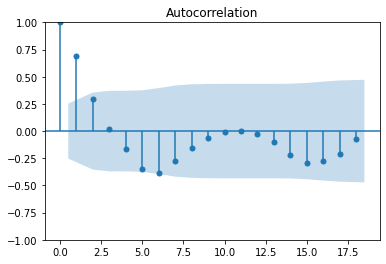

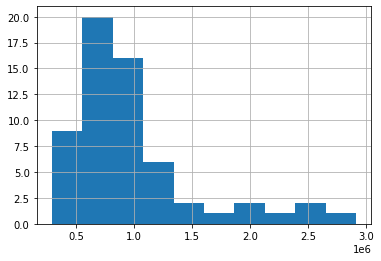

In [4]:
data = sum_past_df.VOLUME
print(f"Mean: {np.mean(data)}")
print(f"SD: {np.std(data)}")
print(f"Skewness (Should be 0) : {skew(data)}")
print(f"Excess kurtosis (Should be 3) : {kurtosis(data)}")
plot_acf(data)
plt.show()
data.hist()
plt.show()

Mean: 13.662693653312642
SD: 0.49995193306250546
Skewness (Should be 0) : 0.23811644103959223
Excess kurtosis (Should be 3) : 0.3789042853425961


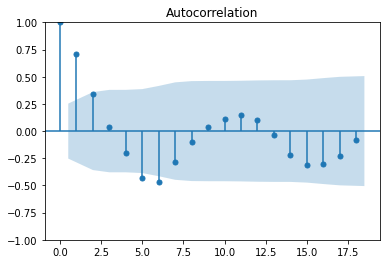

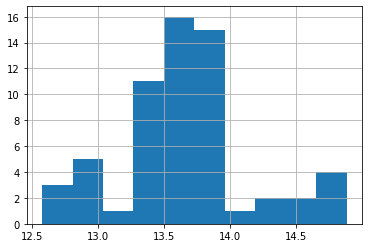

In [5]:
data = np.log(sum_past_df.VOLUME)
print(f"Mean: {np.mean(data)}")
print(f"SD: {np.std(data)}")
print(f"Skewness (Should be 0) : {skew(data)}")
print(f"Excess kurtosis (Should be 3) : {kurtosis(data)}")
plot_acf(data)
plt.show()
data.hist()
plt.show()

Mean: -0.014912759529995729
SD: 0.3537173966121256
Skewness (Should be 0) : -0.01647795052691116
Excess kurtosis (Should be 3) : 0.7797487555946847


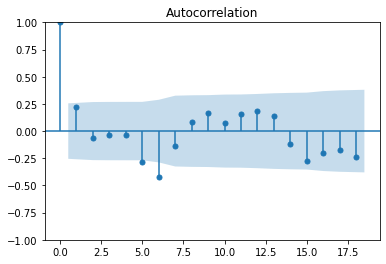

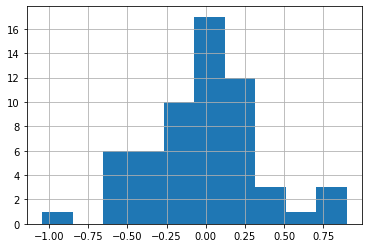

In [6]:
data = np.log(sum_past_df.VOLUME).diff().iloc[1:]
print(f"Mean: {np.mean(data)}")
print(f"SD: {np.std(data)}")
print(f"Skewness (Should be 0) : {skew(data)}")
print(f"Excess kurtosis (Should be 3) : {kurtosis(data)}")
plot_acf(data)
plt.show()
data.hist()
plt.show()

Mean: 0.00906888636293393
SD: 0.44279463982508355
Skewness (Should be 0) : 0.485472890351885
Excess kurtosis (Should be 3) : 0.5279298984190226


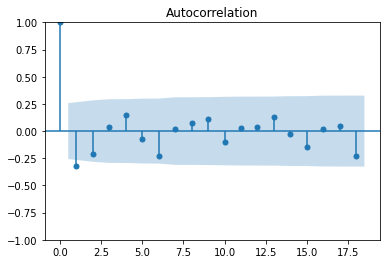

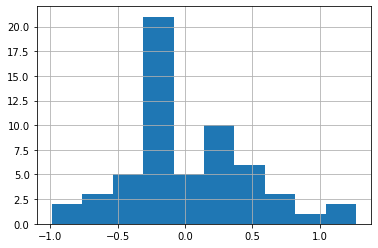

In [7]:
data = np.log(sum_past_df.VOLUME).diff().diff().iloc[2:]
print(f"Mean: {np.mean(data)}")
print(f"SD: {np.std(data)}")
print(f"Skewness (Should be 0) : {skew(data)}")
print(f"Excess kurtosis (Should be 3) : {kurtosis(data)}")
plot_acf(data)
plt.show()
data.hist()
plt.show()

In [8]:
data = np.log(sum_past_df["VOLUME"])
mean = np.mean(data)
std = np.std(data)
data_minus_mean = data - mean
z = data_minus_mean / std

In [9]:
graph_data = data

### 2.2. Check Trend and Seasonality

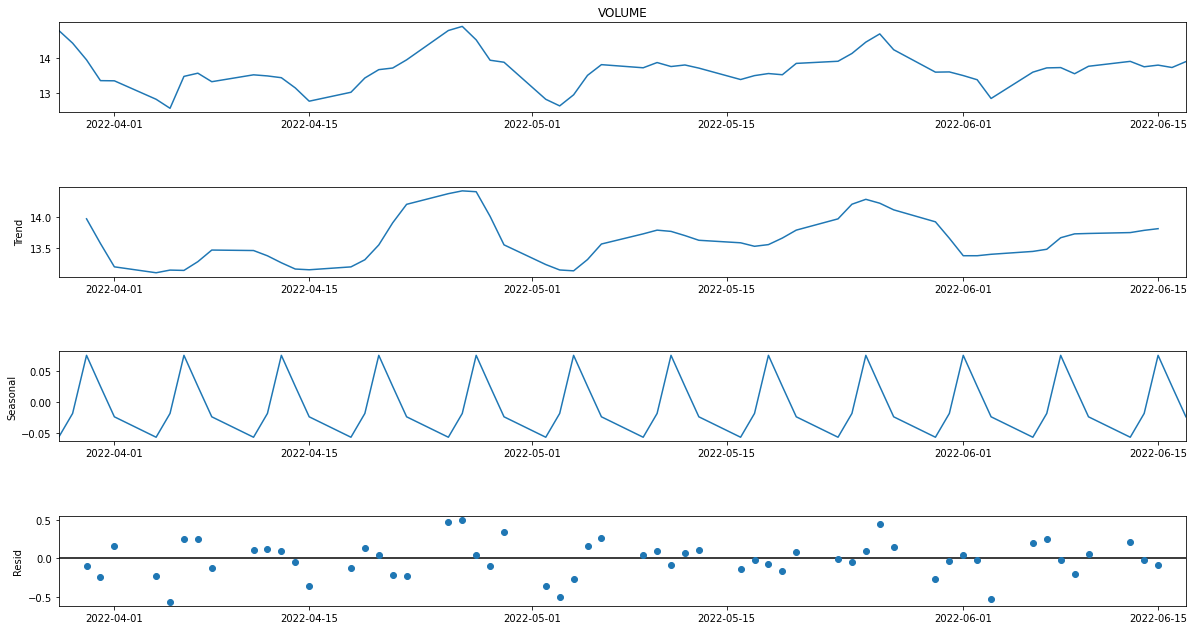

In [10]:
decomposed_data = seasonal_decompose(graph_data, model="add")
fig = decomposed_data.plot()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.show()

From the graphs above, we can see seasonality in every **5 data points (working days)** which corresponds to 1 working week. We will reduce the effect of seasonality by **calculating the daily average traded volume with simple moving average of 5 days**.

### Now check stationarity in the data

ADF test p-value: 0.12


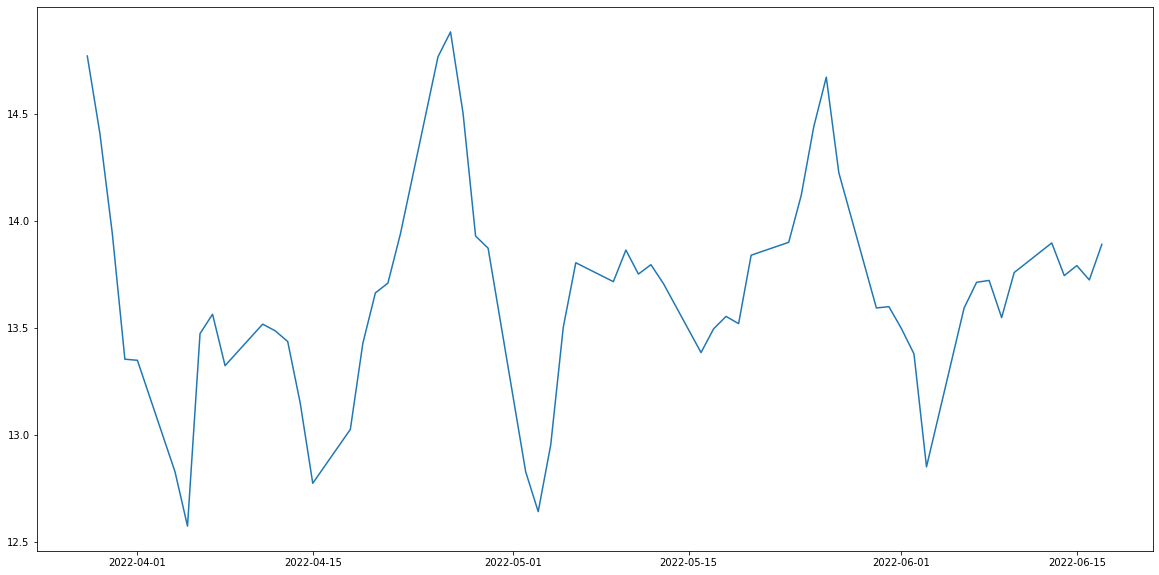

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(graph_data)
print(f"ADF test p-value: {adfuller(graph_data)[1]:.2f}")

**Conclusion: The data is not stationary**

ADF test p-value: 0.0000


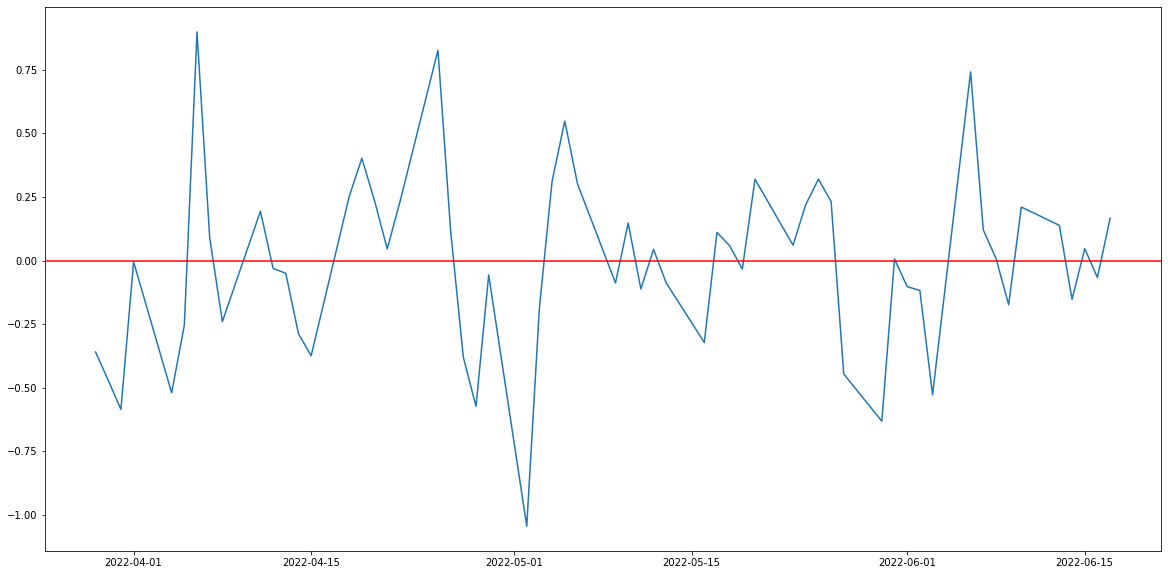

In [12]:
plt.figure(figsize=(20, 10))
plt.plot(graph_data.diff())
plt.axhline(y=0, color="r", linestyle="-")
print(f"ADF test p-value: {adfuller(graph_data.diff()[1:])[1]:.4f}")

#### After 1st order difference, the data becomes stationary

## EDA Conclusion:
Data transformation:
1. Take natural logarithm
2. Calculate 5-day daily average traded volume to remove seasonality
3. Calculate 1st order difference to make the data stationary

In [13]:
def transform(df: pd.DataFrame, window=5) -> pd.DataFrame:
    # Select column VOLUME and calculate the natural log
    ln_df = np.log(df.VOLUME)
    # Calculate the SMA5, remove NA
    rolling_df = pd.DataFrame(ln_df.rolling(window).mean()[window:])
    # Calculate 1st order difference, remove NA
    diff_df = rolling_df.diff().iloc[1:,:]
    return diff_df



In [14]:
data = transform(sum_past_df)
# Rename columm VOLUME to y
data = data.rename(columns={"VOLUME": "y"})

# 3. Train multiple models
We will use:
* Auto ARIMA
* Facebook Prophet
* XGBoost
* Neural Network

In [15]:
TEST_SIZE = 5
train = data.iloc[:-TEST_SIZE]
test = data.iloc[-TEST_SIZE:]

### 3.1. Auto ARIMA

In [16]:
auto_sarimax_model = pm.auto_arima(
    train,
    start_p=1,
    start_q=1,
    m=5,
    d=None,
    seasonal=True,
    start_P=0,
    D=0,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(auto_sarimax_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[5] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=-28.839, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=-92.255, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=-30.834, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[5] intercept   : AIC=-66.077, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[5] intercept   : AIC=-92.598, Time=0.11 sec
 ARIMA(1,0,0)(2,0,1)[5] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[5] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(2,0,0)[5] intercept   : AIC=-58.942, Time=0.09 sec
 ARIMA(2,0,0)(2,0,0)[5] intercept   : AIC=-94.168, Time=0.15 sec
 ARIMA(2,0,0)(1,0,0)[5] intercept   : AIC=-93.547, Time=0.12 sec
 ARIMA(2,0,0)(2,0,1)[5] intercept   : AIC=-102.864, Time=0.25 sec
 ARIMA(2,0,0)(1,0,1)[5] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,0)(2,0,2)[5] intercept   : AIC=inf, Time=0.31 sec
 ARIM

SARIMAX auto MAE =  0.029020321637487956


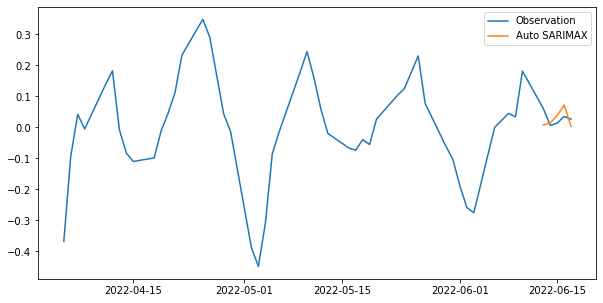

In [17]:
sarimax_prediction_automated = auto_sarimax_model.predict(n_periods=test.shape[0])
sarimax_prediction_automated = pd.DataFrame(
    {
        "ds": test.index,
        "y": sarimax_prediction_automated,
    }
)
sarimax_prediction_automated.set_index("ds", inplace=True)
plt.figure(figsize=(10, 5))
(l1,) = plt.plot(data, label="Observation")
(l2,) = plt.plot(sarimax_prediction_automated, label="Auto SARIMAX")
plt.legend(handles=[l1, l2])
print("SARIMAX auto MAE = ", mean_absolute_error(sarimax_prediction_automated, test))

### 3.2. Facebook Prophet

In [18]:
train["ds"] = train.index.values
train = train.rename(columns={"VOLUME": "y"})
prophet_model = Prophet()
prophet_model.fit(train)
future = prophet_model.make_future_dataframe(periods=test.shape[0])
prophet_prediction = prophet_model.predict(future)
prophet_prediction = prophet_prediction.set_index("ds")
prophet_future = prophet_prediction.yhat[-TEST_SIZE:]
prophet_future.index = test.index
print("Prophet MAE = ", mean_absolute_error(prophet_future, test))

22:50:50 - cmdstanpy - INFO - Chain [1] start processing
22:50:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE =  0.02831359629215998


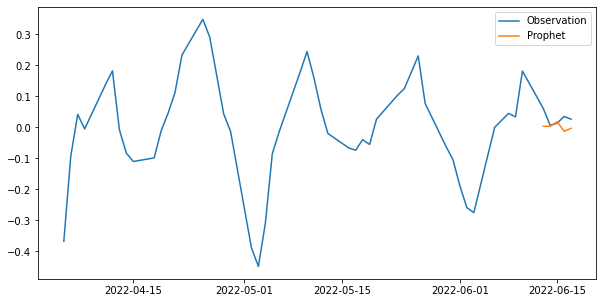

In [19]:
plt.figure(figsize=(10, 5))
(l1,) = plt.plot(data, label="Observation")
(l2,) = plt.plot(prophet_future, label="Prophet")
plt.legend(handles=[l1, l2])

### Feature engineering for XGBoost and Neural Network

In [20]:
def add_features(t, prev_len=5):
    key_cols = range(1, prev_len + 1, 1)
    names = [f"y_{i}" for i in key_cols]
    df_new = (
        pd.concat([t.y.shift(i) for i in key_cols], axis=1, keys=names)
        .dropna()
        .reset_index()
    )
    df_new.drop("date", inplace=True, axis=1)
    t = t.iloc[prev_len:, :]

    X = pd.DataFrame()
    X["day"] = t.index.day
    X["month"] = t.index.month
    X["quarter"] = t.index.quarter
    X["dayofweek"] = t.index.dayofweek
    X["dayofyear"] = t.index.dayofyear
    X["weekofyear"] = t.index.weekofyear
    X["year"] = t.index.year
    X = pd.concat([X, df_new], axis=1)
    y = t.y

    return X, y


display(add_features(data)[0].head())

SIZE_PREV_ROWS = 5
X_data, y_data = add_features(data, prev_len=SIZE_PREV_ROWS)

TEST_SIZE = 5
X_train = X_data.iloc[
    :-TEST_SIZE,
]
y_train = y_data[:-TEST_SIZE]
X_test = X_data.iloc[
    -TEST_SIZE:,
]
y_test = y_data[-TEST_SIZE:]

# display(X_test)
# display(y_test)

,day,month,quarter,dayofweek,dayofyear,weekofyear,year,y_1,y_2,y_3,y_4,y_5
0,12,4,2,1,102,15,2022,0.137834,-0.005011,0.042012,-0.093231,-0.367294
1,13,4,2,2,103,15,2022,0.182483,0.137834,-0.005011,0.042012,-0.093231
2,14,4,2,3,104,15,2022,-0.007412,0.182483,0.137834,-0.005011,0.042012
3,15,4,2,4,105,15,2022,-0.083020,-0.007412,0.182483,0.137834,-0.005011
4,18,4,2,0,108,16,2022,-0.109892,-0.083020,-0.007412,0.182483,0.137834


In [21]:
scaled_train = X_train
scaled_test = X_test

### 3.3. XGBoost

In [22]:
xgb_model = XGBRegressor(n_estimators=7 + SIZE_PREV_ROWS)

In [23]:
xgb_model.fit(
    scaled_train,
    y_train,
    eval_set=[
        (scaled_train, y_train),
        (scaled_test, y_test),
    ],
    verbose=True,
)
xgb_prediction = xgb_model.predict(scaled_test)

[0]	validation_0-rmse:0.38089	validation_1-rmse:0.29285
[1]	validation_0-rmse:0.28162	validation_1-rmse:0.19742
[2]	validation_0-rmse:0.20820	validation_1-rmse:0.18185
[3]	validation_0-rmse:0.15534	validation_1-rmse:0.13188
[4]	validation_0-rmse:0.11781	validation_1-rmse:0.10301
[5]	validation_0-rmse:0.09001	validation_1-rmse:0.08128
[6]	validation_0-rmse:0.06970	validation_1-rmse:0.06477
[7]	validation_0-rmse:0.05420	validation_1-rmse:0.05021
[8]	validation_0-rmse:0.04250	validation_1-rmse:0.04529
[9]	validation_0-rmse:0.03353	validation_1-rmse:0.04233
[10]	validation_0-rmse:0.02671	validation_1-rmse:0.04274
[11]	validation_0-rmse:0.02148	validation_1-rmse:0.04292


In [24]:
print("XGBOOST MAE = ", mean_absolute_error(xgb_prediction, y_test))

XGBOOST MAE =  0.03879650848971252


### 3.4. Neural Network

In [25]:
NN_model = Sequential()
NN_model.add(Dense(24, input_shape=(scaled_train.shape[1],)))
NN_model.add(Dense(12))
NN_model.add(Dense(6))
NN_model.add(Dense(1))
NN_model.compile(loss="mean_absolute_error", optimizer=Adam(lr=0.0004))
NN_model.fit(
    scaled_train,
    y_train,
    validation_data=(scaled_test, y_test),
    epochs=1000,
    verbose=False,
)
NN_prediction = NN_model.predict(scaled_test)

1/1 [==============================] - 0s 63ms/step


In [26]:
print(f"XGBOOST MAE = {mean_absolute_error(xgb_prediction, y_test):.4f}")
print(f"Prophet MAE = {mean_absolute_error(prophet_future, y_test):.4f}")
print(f"SARIMAX MAE = {mean_absolute_error(sarimax_prediction_automated, y_test):.4f}")
print(f"NN MAE = {mean_absolute_error(NN_prediction, y_test):.4f}")


# Check the MAE of test data.
# We can compare this MAE with other models' MAE to give sense if the model we generated is good enough
print(
    f"Test data MAE: {mean_absolute_error(np.array([mean] * test.shape[0]), y_test):.4f}"
)

display_markdown("## Conclusion: The best performing model is Prophet", raw=True)

XGBOOST MAE = 0.0388
Prophet MAE = 0.0283
SARIMAX MAE = 0.0290
NN MAE = 0.6187
Test data MAE: 13.6342


## Conclusion: The best performing model is Prophet

### Now compare how the four models perform when predicting test values

<Figure size 1440x1440 with 0 Axes>

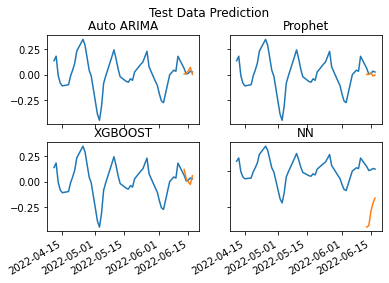

In [27]:
xgb_df = pd.DataFrame({"y": xgb_prediction.tolist()})
xgb_df.index = y_test.index

NN_df = pd.DataFrame(NN_prediction)
NN_df.index = y_test.index
plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 2)
fig.suptitle("Test Data Prediction")
axs[0, 0].plot(data.tail(50))
axs[0, 0].plot(sarimax_prediction_automated.tail(50))
axs[0, 0].set_title("Auto ARIMA")
axs[0, 1].plot(data.tail(50))
axs[0, 1].plot(prophet_future.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(data.tail(50))
axs[1, 0].plot(xgb_df.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(data.tail(50))
axs[1, 1].plot(NN_df.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

## 4. Predict the future

In [33]:
future_files = [
    "../data/0620FUT.csv",
    "../data/0621FUT.csv",
    "../data/0622FUT.csv",
    "../data/0623FUT.csv",
    "../data/0624FUT.csv",
]
future_df = pd.DataFrame()
for future_file in future_files:
    new_df = pd.read_csv(future_file)
    future_df = future_df.append(new_df)

sum_future_df = future_df.groupby(by="DATE").sum().reset_index()
sum_future_df["date"] = pd.to_datetime(sum_future_df["DATE"], format="%Y%m%d")
sum_future_df = sum_future_df.set_index("date")
sum_future_df = sum_past_df.append(sum_future_df)

# Transform data
transformed_data = transform(sum_future_df)
# Rename columm VOLUME to y
transformed_data = transformed_data.rename(columns={"VOLUME": "y"})

### At this point, we lose 6 data points

In [35]:
TEST_SIZE = 5
train = transformed_data.iloc[:-TEST_SIZE, :]
test = transformed_data.iloc[
    -TEST_SIZE:,
]
train["ds"] = train.index.values

prophet_model = Prophet()
# Model training
prophet_model.fit(train)
# Predict next week volume
future = prophet_model.make_future_dataframe(periods=TEST_SIZE)
prophet_prediction = prophet_model.predict(future)
prophet_prediction = prophet_prediction.set_index("ds")
prophet_future = prophet_prediction.yhat[-TEST_SIZE:]
prophet_future.index = transformed_data.index[-TEST_SIZE:]
print("Prophet MAE = ", mean_absolute_error(prophet_future, test))

22:52:45 - cmdstanpy - INFO - Chain [1] start processing
22:52:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE =  0.0497493999092186


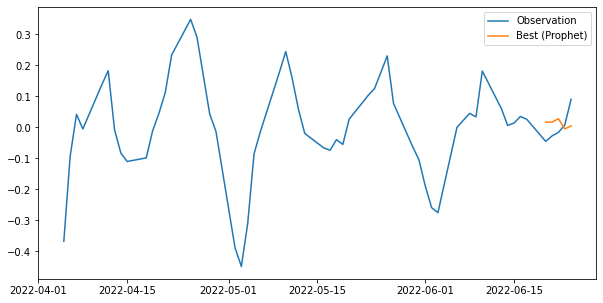

In [36]:
plt.figure(figsize=(10, 5))
(l1,) = plt.plot(transformed_data, label="Observation")
(l2,) = plt.plot(prophet_future, label="Best (Prophet)")
plt.legend(handles=[l1, l2])